In [21]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import umap
import matplotlib.pyplot as plt


In [22]:
transform = transforms.Compose([
    transforms.ToTensor()
])


In [23]:
transform = transforms.ToTensor()

dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [24]:
def mask_images(images, mask_ratio=0.75):
    mask = torch.rand_like(images) > mask_ratio
    return images * mask


In [25]:
images, _ = next(iter(loader))

masked_images = mask_images(images)



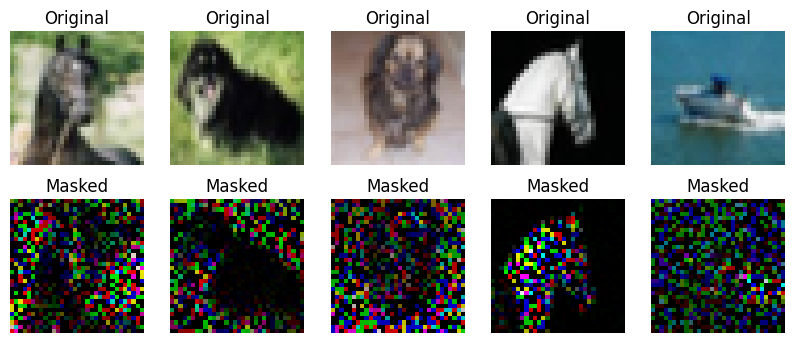

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    # Original image
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Masked image
    axes[1, i].imshow(masked_images[i].permute(1, 2, 0))
    axes[1, i].axis("off")
    axes[1, i].set_title("Masked")

plt.show()


In [27]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256)
        )

    def forward(self, x):
        return self.net(x)


In [28]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(256, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [29]:
class MAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [31]:
for epoch in range(5):
    for images, _ in loader:   # labels ignored
        images = images.to(device)

        masked = mask_images(images)      # hide parts
        recon = model(masked)             # rebuild image
        loss = loss_fn(recon, images)     # compare to original

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.0164
Epoch 1, Loss: 0.0126
Epoch 2, Loss: 0.0121
Epoch 3, Loss: 0.0098
Epoch 4, Loss: 0.0088


In [32]:
model.eval()

embeddings = []
labels = []


In [33]:
with torch.no_grad():
    for images, lbl in loader:
        images = images.to(device)

        z = model.encoder(images)   # embeddings
        embeddings.append(z.cpu())
        labels.append(lbl)


In [34]:
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

In [35]:
import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_components=2, random_state=42)
emb_2d = umap_model.fit_transform(embeddings)


/Users/light/Desktop/university_work/amlfinal/.amlfinal/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


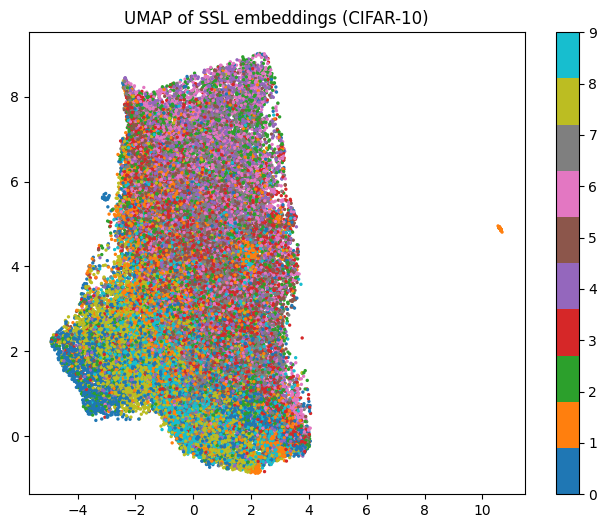

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    cmap="tab10",
    s=2
)
plt.colorbar()
plt.title("UMAP of SSL embeddings (CIFAR-10)")
plt.show()


In [37]:
for param in model.encoder.parameters():
    param.requires_grad = False


In [38]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(256, 10)  # CIFAR-10 = 10 classes

    def forward(self, x):
        return self.fc(x)


In [39]:
classifier = Classifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)


In [40]:
for epoch in range(5):
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = model.encoder(images)  # fixed encoder

        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.8855
Epoch 1, Loss: 1.8274
Epoch 2, Loss: 1.7311
Epoch 3, Loss: 1.7352
Epoch 4, Loss: 1.6962


In [42]:
correct_samples = []
wrong_samples = []

classifier.eval()
model.eval()

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        embeddings = model.encoder(images)
        outputs = classifier(embeddings)

        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            sample = {
                "image": images[i].cpu(),
                "true": labels[i].item(),
                "pred": predicted[i].item()
            }

            if predicted[i] == labels[i]:
                correct_samples.append(sample)
            else:
                wrong_samples.append(sample)


In [43]:
def show_samples(samples, title, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        img = samples[i]["image"].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(
            f"T:{samples[i]['true']} P:{samples[i]['pred']}"
        )
    plt.suptitle(title)
    plt.show()


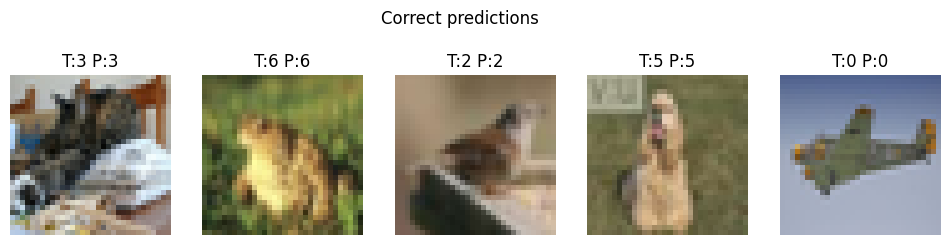

In [44]:
show_samples(correct_samples, "Correct predictions")


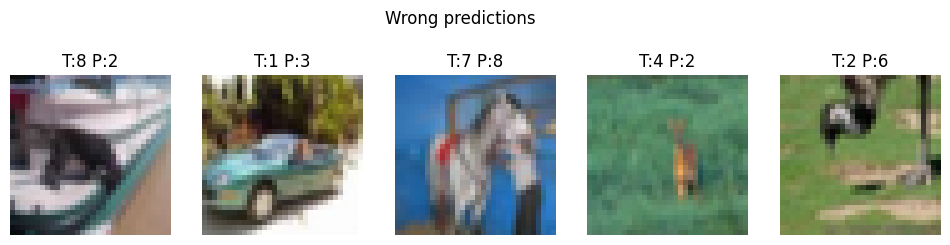

In [45]:
show_samples(wrong_samples, "Wrong predictions")
